In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [2]:
# Read the Data
# 'ISO-8859-1' we need this because some csv include some invalid characters
df = pd.read_csv('spam.csv' , encoding='ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Here we Are dropping unnecessary columns
df = df.drop(["Unnamed: 2" , "Unnamed: 3" , "Unnamed: 4"], axis=1)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# lets Rename the columns to understand it better
df.columns = ['labels' , 'data']

In [7]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


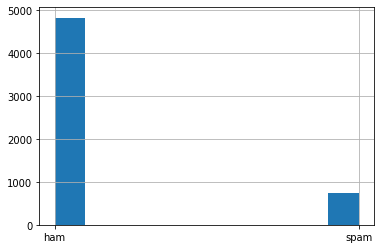

In [8]:
# next step we are drowing a histogram of our labels , wll help us to determine whether or not we have imbalanced classes
df['labels'].hist()

In [9]:
# Here we are creating binary labels setting the 0 for ham and 1 spam to represented numerically
df['b_labels'] = df['labels'].map({'ham': 0 , 'spam': 1})
Y = df['b_labels'].to_numpy() # here we are extracting this column as numpy array

In [26]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
# splitting the data into train and test
df_train , df_test , Ytrain , Ytest = train_test_split(df['data'] , Y , test_size = 0.33)

In [11]:
print(df_train)

3769    Love it! The girls at the office may wonder wh...
5471                                                  Yup
5547    Had your contract mobile 11 Mnths? Latest Moto...
3262                              So u gonna get deus ex?
1543    Hello from Orange. For 1 month's free access t...
                              ...                        
5531    Compliments to you. Was away from the system. ...
429     I wnt to buy a BMW car urgently..its vry urgen...
204                             U call me alter at 11 ok.
3823    I miss you so much I'm so desparate I have rec...
3775                            Ok lor. Msg me b4 u call.
Name: data, Length: 3733, dtype: object


In [12]:
print(Ytrain)

[0 0 1 ... 0 0 0]


In [13]:
# next step now creating sparse matrix , which contains the input feature for every sample
# here we are using countVectorizer from Sklearn libary
featurizer = CountVectorizer(decode_error = 'ignore') # we passing decode error here because if we found any invalid UTF characters we just want ignore them
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [14]:
# lets print see what we got back
Xtrain

<3733x7111 sparse matrix of type '<class 'numpy.int64'>'
	with 49500 stored elements in Compressed Sparse Row format>

In [15]:
# now we have to create the model , train it , print scores
# we used MultinomialNB classfier
model = MultinomialNB()
model.fit(Xtrain , Ytrain)
print ("train acc:", model.score(Xtrain , Ytrain))
print("test acc:", model.score(Xtest, Ytest) )

train acc: 0.9930350924189659
test acc: 0.9891245241979336


In [16]:
# because our classes are imbalanced and the accurcy might not be best measure of performance
# we gonna check other metrics
# first alternative F1 score
#F1 score which bases on precision and recall 
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:" , f1_score(Ytrain , Ptrain))
print("test F1:" , f1_score (Ytest , Ptest))

train F1: 0.9742063492063492
test F1: 0.9574468085106382


In [17]:
#Here we checking the AUC as another alternative measure of performance
#the good thing with AUC it’s considers the distribution of true and false positives and negatives 
Prob_train = model.predict_proba(Xtrain)[:,1]
Prob_test = model.predict_proba(Xtest)[:,1]
print("train AUC:" , roc_auc_score(Ytrain , Prob_train))
print("test AUC:" , roc_auc_score(Ytest,Prob_test))


train AUC: 0.9934452513439592
test AUC: 0.9822651758681754


In [18]:
# in the next step here we are cheking if we can see a better view of a model's perfomance by looking at confusion matricx
cm = confusion_matrix(Ytrain , Ptrain)
cm

array([[3216,   11],
       [  15,  491]])

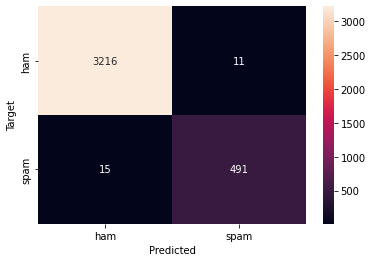

In [20]:
def plot_cm(cm):
  classes = ['ham' , 'spam']
  df_cm = pd.DataFrame(cm,index=classes,columns = classes)
  ax = sn.heatmap(df_cm,annot=True , fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

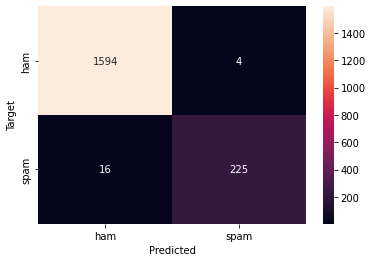

In [21]:
cm_test = confusion_matrix(Ytest , Ptest)
plot_cm(cm_test)

In [23]:
#this function provides a way to see the most common words in dataset
# used for see what are the common words for spam or ham
def visulaize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width = 600 , height = 400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

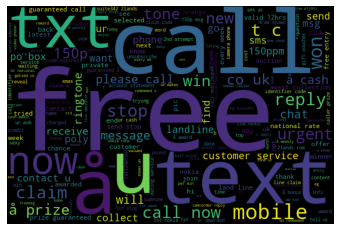

In [24]:
visulaize('spam')

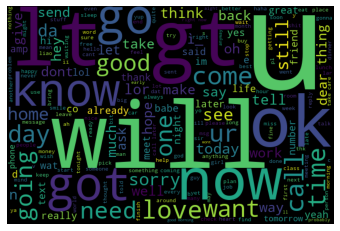

In [25]:
visulaize('ham')

In [27]:
#in this step we’re doing predictions on the entire dataset using the trained model ,
# we doing this step to which data points are being misclassified 
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [28]:
df.head()

,labels,data,b_labels,predictions
0,ham,"Go until jurong point, crazy.. Available only ...",0,0
1,ham,Ok lar... Joking wif u oni...,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,1
3,ham,U dun say so early hor... U c already then say...,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0


In [ ]:
#we creating function to see what are the messages that were labeled as spam but were incorrectly predicted as ham by the model
sneaky_spam = df [(df['predictions']== 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam :
  print(msg)

In [ ]:
#last function is the opposite messages that were labeled as ham but were incorrectly predicted as spam by the model 
not_actually_spam = df [(df['predictions']== 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam: 
  print(msg)